# Summary

*Author: Benjamin Bradshaw*

Welcome to the Evidation Data Science Module! This module is designed to give you an introduction to the world of health data science. This is a fascinating field that combines traditional forms of data with data derived from internet-of-things devices (IoT) such as Fitbits, wireless scales, continuous glucose monitors and many, many more devices.

Data Science is part science, part engineering. A theme we will continually stress in this module is how to use software engineering principals to create *scalable science*. Cheap computing power, in combination with open software libraries such as pandas, sklearn, and tensorflow have made it possible to conduct analysis that were not possible just a few years ago, and we will show you how to use some of these tools to build your own solutions to novel problems.

This notebook will focus on the twofold process of *ETL* and *sample selection*. *ETL* is short for *Extract-Transform-Load* and is traditionally a software engineering process to parse data into an appropriate format for storage or analysis. *Sample selection* is a well known practice in statistics and refers to choosing an appropriate subset of a collected dataset in order to minimize bias or maximize out of sample prediction accuracy. Data science uses both of these tools and in this notebook we will give you an example of how to do just that.

Throughout this module we will use two sources of data. The in class notebooks will use the NHANES data set: a large dataset collected by the CDC that records a huge breadth of data about a large set of individuals, including raw accelerometer data for a subset of these study participants. The exercises will use Fitbit data: you will learn how to create your own Fitbit application to pull intraday steps data, and you will then use that data to conduct further analysis.

In this notebook we will cover the following topics:
- Pull down several raw datasets contained on the 2005-2006 [NHANES website](https://wwwn.cdc.gov/nchs/nhanes/ContinuousNhanes/Default.aspx?BeginYear=2005). We'll do this using a combination of bash and pandas: bash for the datasets that need to be unzipped, pandas for those we can read directly from source.
- Store the raw SAS format data as something more reasonable and modern (I'm going to use [HDF format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) which is a super fast binary data representation, but feel free to play around with .h5 or another format as you see fit)
- Correct outlier detection and correctin on the raw NHANES accelerometer data
- Conduct sample selection using the raw data in order to do further analysis later

# Learning Objectives

After completing this module you should be able to do the following:

1. Use pandas to pull raw data from source
2. Use ```wget``` and ```unzip``` to pull in data that can't be read directly from source via pandas
3. Understand why data compression is important, and how to downcast datatypes for efficient memory allocation
4. Construct basic visualization tools for checking data quality
5. Understand the basics of outlier detection for IoT signal data, and implement basic outlier correction
6. Conduct sample selection using various inclusion criteria in order to create a dataset useful for further analysis

# Initialize

Below are the external dependencies this notebook depends on to function. If you don't have these installed you can install them using pip or conda- whichever you typically use as your package manager.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utils # Utility functions containained in ./utils/
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)

# Change this location to the path where you would like your data saved to
data_dir = '/Users/bbradshaw/nhanes/'

# Path to hdf store we will create later
hdf_path = 'nhanes.h5'

# Download, unzip, and save raw physical activity monitor data.

The raw PAX data is zipped due to its size and can't be read directly into pandas. We use the following steps to get it into a more manageable format:
1. Download the data using the bash command ```wget```
2. Unzip the downlaoded data using the bash command ```unzip```
3. Read the data into pandas, and downcast data types to save on memory. The machine we are using has 32G of RAM, if your machine has less you may have issues with this step. If that's the case we suggest you don't actually run this portion of the ETL pipeline but rather use the ```nhanes.h5``` store we have written out and supplied to you.

In [3]:
###############################################################
# RUN THIS BLOCK ONLY IF YOU WANT TO RECREATE THE ETL PROCESS # 
# OTHERWISE READ THE PREPROCESSED FILE - IT TAKES FOREVER     #
# AND ISN'T THAT INTERESTING                                  #
###############################################################

! wget https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
! mv PAXRAW_D.ZIP {data_dir}
! unzip {data_dir}PAXRAW_D.ZIP -d {data_dir}

--2018-04-16 14:56:25--  https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
Resolving wwwn.cdc.gov... 198.246.102.39
Connecting to wwwn.cdc.gov|198.246.102.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470990068 (449M) [application/x-zip-compressed]
Saving to: ‘PAXRAW_D.ZIP’

PAXRAW_D.ZIP        100%[===================>] 449.17M   925KB/s    in 9m 58s  

2018-04-16 15:06:24 (769 KB/s) - ‘PAXRAW_D.ZIP’ saved [470990068/470990068]

Archive:  /Users/bbradshaw/nhanes/PAXRAW_D.ZIP
  inflating: /Users/bbradshaw/nhanes/paxraw_d.xpt  


In [4]:
#############################################################
# AGAIN - ONLY RUN THIS BLOCK IF YOU ARE CURIOUS, IT TAKES  # 
# A LONG TIME, AND IT'S EASIER/FASTER TO USE THE HDF STORE  #
# WE PROVIDE THAT HAS ALREADY PROCESSED THE DATA            #
#############################################################
! python -m xport {data_dir}paxraw_d.xpt > {data_dir}paxraw_d.csv

In [14]:
# Using the default float types is extremely memory intensive 
# given the number of rows we are dealing with. 

# Let's define a map that casts columns to less memory
# intensive types
type_map = {
    'SEQN': 'object',
    'PAXSTAT': np.int8,
    'PAXCAL': np.int8,
    'PAXDAY': np.int8,
    'PAXHOUR': np.int16,
    'PAXMINUT': np.int16,
    'PAXINTEN': np.int16,
    'PAXSTEP': np.float32,
    'PAXN': np.int16
}

In [15]:
# Read the csv file we just created into memory in order to downcast
# We can pass type_map to pd.read_csv to specify the types we want
pax_path = 'paxraw_d.csv'
%time pax_raw = pd.read_csv(os.path.join(data_dir, pax_path), dtype=type_map)

CPU times: user 1min 37s, sys: 8.36 s, total: 1min 45s
Wall time: 1min 51s


**Side Note:** The ```%time``` magic command. Jupyter notebooks has several useful "magics" commands. The ```%time``` command allows us to time how long a command takes to run. The command will return both CPU times as well as wall times. If you aren't sure what that means, we encourage you to google it to learn more!

In [10]:
# pythonize column names
pax_raw.columns = [x.lower() for x in pax_raw.columns]

In [11]:
# Display dataframe types and usage statistics
pax_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74874095 entries, 0 to 74874094
Data columns (total 9 columns):
seqn        object
paxstat     int8
paxcal      int8
paxday      int8
paxn        int16
paxhour     int16
paxminut    int16
paxinten    int16
paxstep     float32
dtypes: float32(1), int16(4), int8(3), object(1)
memory usage: 1.6+ GB


You can see that downcasting our types saved us a *significant* amount of memory (prior to specifying the datatypes the datframe was consuming 8+ GB of memory). We manually inferred the best datatypes, but for datasets with larger numbers of columns it would be more efficient to automatically infer the datatypes.

We will store our data in an HDF store. An HDF store is very similar to a database like SQLite or PostgreSQL in that you can store several tables under one store. Additionally, HDF preserves python data types between write and read- which is a very nice property for dates or in our case memory savings. You can see in the code block below that we can list the table keys stored in our HDF store. Finally, I/O operations are *much* faster than file formats such as csv, sometimes by as much as 100x.

In [13]:
pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

# Read other NHANES tables directly from source

The other tables aren't compressed- they are simply raw .XPT files written out via SAS. We can read directly from source. There are a TON of interesting files on the NHANES website- from disease state questionnaires to physical activity questionnaires. We have linked a few interesting tables below, we will leave it to you to add the rest.

In [14]:
# In order to grab tables from the CDC NHANES website, simply add a table alias to the dictionary below,
# and then reference the table link address as the corresponding key value. The read_sas_write_feather
# function in utils will then read each sas file and write it to write_dir in feather format using 
# the alias as the file name

source_paths = {
    'medical_conditions_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/MCQ_D.XPT',
    'weight_history_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/WHQ_D.XPT',
    'demographics_with_sample_weights': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.XPT'
}

In order to optimize I/O, and keep all of our data in one place, we'll download each of the raw datasets we are interested in into memory, then save it to our already created HDF store.

In [29]:
utils.read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5')

/Users/bbradshaw/venv3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->['seqn']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [2]:
with pd.HDFStore(os.path.join(data_dir, 'nhanes.h5')) as hdf:
    print(hdf.keys())

['/demographics_with_sample_weights', '/medical_conditions_questionnaire', '/pax_clean', '/pax_raw', '/weight_history_questionnaire']


Looks like all requested tables made it safely into our data store!

## Exercise: Find and read the physical activity questionnaire

Find the raw SAS file on the 2005-2006 NHANES website that corresponds to the physical activity questionnaire. Use the function ```utils.read_sas_write_hdf()``` to download this file and write it into the HDF store that contains the other tables we already downloaded above.

In [27]:
######################
# YOUR SOLUTION HERE #
######################

## Solution: Find and read the physical activity questionnaire

In [ ]:
append_paths = {
    'physical_activity_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAQ_D.XPT'
}

In [ ]:
utils.read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5', downcast=False, verbose=False)

# Initial QC of physical activity data

In order to verify that the raw physical activity data looks reasonable, we will create a some tools that will allow us to quickly visualize the time series that correspond to each user-day's walking patterns. There are a few good reasons for doing this:
1. This will allow us to infer if our preprocessing worked correctly
2. It will allow us to identify idiosyncracies in the raw data itself
3. It will help us better understand what sorts of features could be useful for various prediction or inference problems

In [51]:
######################################################
# Running this block on the UCSB machines causes the #
# kernel to fail due to lack of available memory,    #
# if you are interested in using the whole dataset   #
# you will need to use a more powerful machine.      #
######################################################

# If running the ETL pipeline on the full dataset, set True
# using_sample = False

# %time pax_raw = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

CPU times: user 3.63 s, sys: 5.41 s, total: 9.05 s
Wall time: 10.4 s


In [82]:
######################################################
# This block grabs 10% of participants and generates #
# an activity sample from that. For the UCSB         #
# machines I recommend you use this for working      #
# through the notebooks since they don't have enough #
# memory for the full pre-processed dataset. You     #
# don't need to run this block, unless you want to   #
# recreate the sample from scratch.                  #
######################################################

# If we are running the ETL pipeline on a sample, set True
using_sample = True

# pax_raw = utils.construct_person_sample(pax_raw)
# pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_raw_sample')

In [54]:
%time pax_raw = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_raw_sample')

CPU times: user 293 ms, sys: 207 ms, total: 499 ms
Wall time: 501 ms


Note the incredible increase in speed when we read the accelerometer data from the hdf store rather than from the csv file: from a wall time of 117 seconds to a wall time of < 15 seconds! (on my Macbook Air)

In [55]:
# Add a "minute of day" column as a plotting index
pax_raw['minute_of_day'] = pax_raw.paxhour*60 + pax_raw.paxminut
pax_raw.head()

,seqn,paxstat,paxcal,paxday,paxn,paxhour,paxminut,paxinten,paxstep,minute_of_day
0,31151.0,1,1,1,1,0,0,0,0.0,0
1,31151.0,1,1,1,2,0,1,0,0.0,1
2,31151.0,1,1,1,3,0,2,0,0.0,2
3,31151.0,1,1,1,4,0,3,0,0.0,3
4,31151.0,1,1,1,5,0,4,0,0.0,4


In [56]:
# Take the raw data and filter out a single person just to check if the data looks reasonable.
test_id = pax_raw.seqn.values[1]
pax_sample = pax_raw[pax_raw.seqn==test_id].copy()

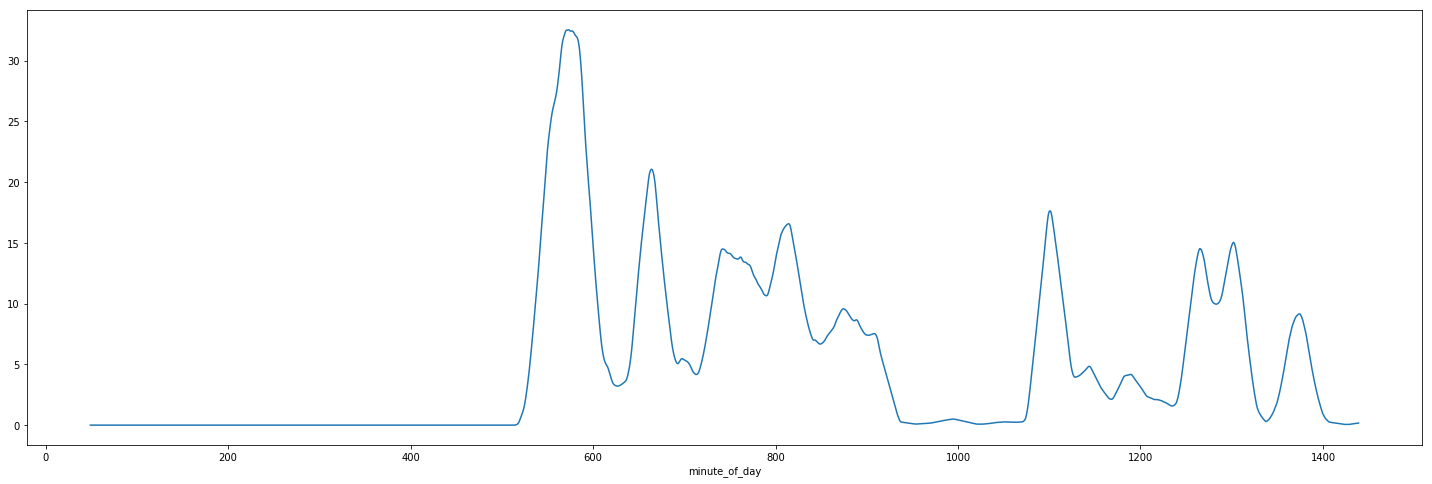

In [57]:
# Plot the 30-minute rolling walk step series for our sampled user over day 1
pax_sample[pax_sample.paxday==1]\
    .set_index('minute_of_day')\
    .paxstep.rolling(window=50, win_type='triang')\
    .mean()\
    .plot(figsize=(25,8))
    
# Note: I'm using the line continuation character \ in conjunction with
# method chaining here.

We just did some hand coding to plot a single user-day, but what if we wanted to explore *many* user days? It would be helpful to build a tool that would allow us to quickly look at different days and different users in our data.

## Exercise: Plotting user day series

Using the example code above, define a function ```plot_user_steps()``` that takes 4 arguments as input and plots a specific user's rolling walk step plot simialr to the plot shown above. The function's arguments should be:
1. ```pax_df``` (pandas dataframe) The physical activity dataframe
2. ```seqn_id``` (str) The unique study participant id
3. ```day_of_study``` (int) The day of the study to plot
4. ```window_len``` (int) The window length to use for the moving average.

The function should then plot the rolling walk series for a specific user, for a specific day. As a bonus, build in functionality so that passing ```None``` to the parameter ```seqn_id``` will default to choosing a random id from the set of seqn ids and using that to create the plot.

**Side Note: Building Data Science Tools**
A lot of what practicing data scientists do on a daily basis revolves around building tools that solve specific problems pertaining to an analysis. In fact, some may argue that's what seperates a data scientist from your everyday analyst. During this module we really want to encourage you to build tools that make analysis scale. In the process you may even find that it can be very fun and rewarding to create a useful suite of analysis tools to speed up your workflow!

In [10]:
######################
# YOUR SOLUTION HERE #
######################

## Solution: Plotting user day series

We wrote a little snippet of code that implements the solution above. If you are curious how we did it, take a look in the ```utils``` folder that was imported at the top of the notebook.

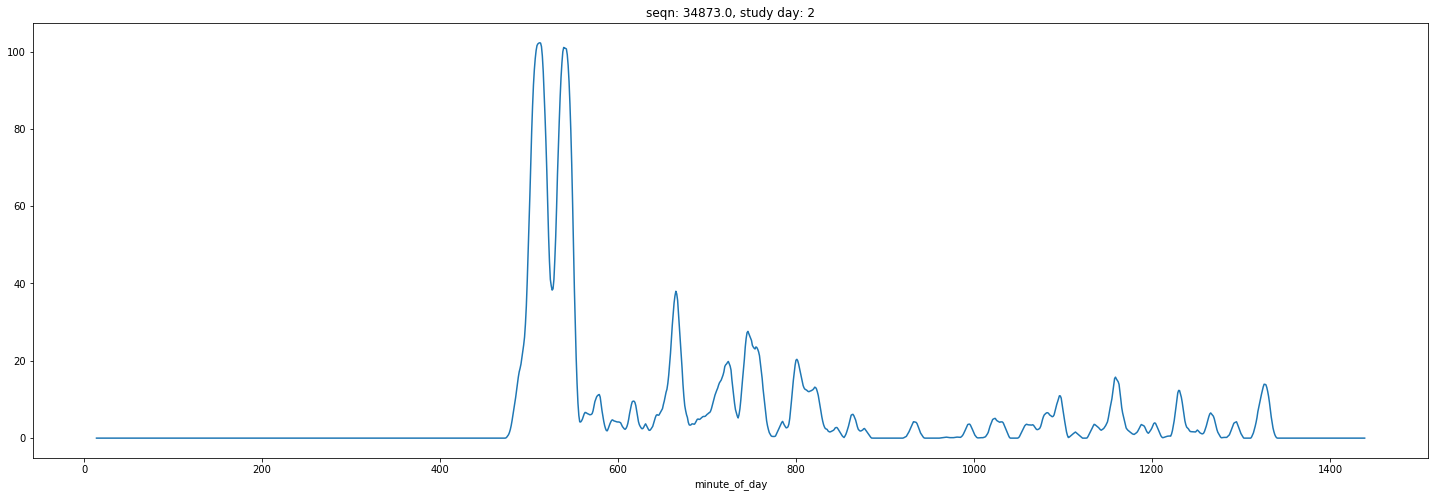

In [58]:
# Look in the utils library to see how we implemented the solution.
utils.plot_user_steps(pax_raw, None, 2, 15)

# Cleaning the raw PAQ data

IoT data can be pretty messy: often times we have long sequences of missing values or we find that sensor malfunctions lead to large outliers in a signal. In order to make our lives a bit easier, we are going to do some initial quality control (QC) on the data. There are a few things we should consider:

1. The paxcal column indicates whether a person's monitor was calibrated or not. In order to ensure we only conduct analysis on valid data, we should discard observations where the monitor was not calibrated.
2. Participants *should* have worn the device during all waking hours. It's doubtful as to whether participants complied with this- so we need to figure out a way to check.
3. Participants were expected to wear the device for 7 days, however many didn't. We are going to restrict our sample to only those participants who had at least 4 valid days (this is common in the literature that uses the NHANES data set)

## Cleaning Part I: Filtering miscalibrated devices

The ```paxcal``` column indicates whether a participant's device was calibrated during a particular period of the study. Let's do some investigation in order to identify users with a high percentage of miscalibrated time

In [59]:
# Map values to something more reasonable
cal_map = {
    1:1, # Keep 1 as meaning "calibrated"
    2:0 # Set 2 to 0 to mean "not calibrated"
}

# Map old values using our new map
pax_raw['paxcal'] = pax_raw.paxcal.map(cal_map)

In [60]:
# Check proportion of calibrated minutes vs not: 1 id calibrated, else 0
pax_raw.paxcal.value_counts() / len(pax_raw)

1    0.952856
0    0.047144
Name: paxcal, dtype: float64

In [61]:
# Check if users could be in calibration for only some days
pax_raw.groupby('seqn').paxcal.mean().value_counts()

1    711
0     35
Name: paxcal, dtype: int64

It appears about 5% of observations are associated with a device that wasn't calibrated. We'll simply exclude those users/observations.

In [62]:
pax_raw = pax_raw[pax_raw.paxcal==1].copy() # Keep only users with a calibrated device
pax_raw.drop(columns='paxcal', inplace=True) # Drop the calibration column, we no longer need it

Now, lets look at the distribution of steps/minute to get an idea of how steps are distributed.

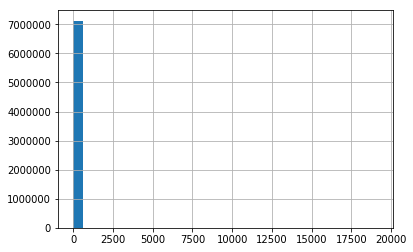

In [63]:
pax_raw.paxstep.hist(bins=30)

The above histogram is pretty worthless. What is going on here? **Stop and think for a moment. What should the distribution of walk steps look like?** Most of our days are spent *seated* meaning that we record zero steps during those minutes. A normal walking pace is around 100 steps per minute. If you are really running you may record 300+ steps per minute. So we expect the majority of the step density to be clustered at zero, perhaps like an exponential distribution. 

As a first invstigation, let's restrict our data to only minutes where observed steps are less than 300 and check out what the distrubution looks like.

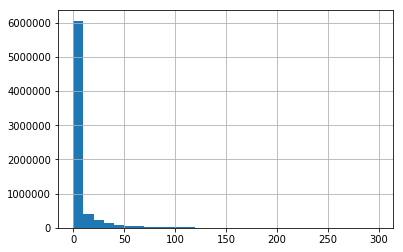

In [64]:
step_threshold = 300
pax_raw[pax_raw.paxstep<step_threshold].paxstep.hist(bins=30)

Now the histogram is more infomative. Indeed, this confirms our prior: most minutes are spent seated, a moderately sized proportion are spent walking, and very few are spent at high intensities. Moreover, we suspect that some large outliers may be influencing the data. Let's investigate.

## Cleaning Part II: Handling outliers

In [65]:
pax_raw.paxstep.describe()

count    7.130569e+06
mean     6.922101e+00
std      5.616775e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.916400e+04
Name: paxstep, dtype: float64

The max value is suspicious: 32,670 steps recorded in a minute? That seems superhuman! Indeed, too good to be true. It appears that the accelerometer that logs steps sometimes produces large outliers that are orders of magnitude larger than normal observations. This is a problem we will need to fix. In order to do so, we should identify a *reasonable threshold that meets the common sense test*. What is the common sense test? While it isn't a statistical test, it may actually be the most important test to master in data science. We simply need to ask ourselves, what is a reasonable number of steps $s$ for which it would be unlikely that a sensor reading above $s$ is legitimate?

In [66]:
pct_outliers = len(pax_raw[pax_raw.paxstep>step_threshold]) / len(pax_raw)*100
print(f'Percent of minutes with > {step_threshold} steps: {pct_outliers}')

Percent of minutes with > 300 steps: 0.12467436010779494


So we have chosen a "reasonable" threshold of 300 steps/minute. Now what? We have a few options. We could:
- Drop the observations that are above our threshold (this is not ideal given that we are dealing with time series data)
- Set these observations to a null value, and then fill them using some yet to be defined strategy
- "Winsorize them" meaning we set them to a fixed percentile value drawn from the distribution of steps

Each of these strategies forces us to make assumptions about the data that may not be true. It's up to us as the practitioner to decide which methods will help us best accomplish the goal at hand- whether that is inference or prediction. In a prediction setting, you could actually determine the "best" strategy using a data driven approach via cross validation. We should probably explore *why* we see outliers before making any decisions.

In [67]:
# Where are the "outliers"?
pax_raw[pax_raw.paxstep > step_threshold].tail(20)

,seqn,paxstat,paxday,paxn,paxhour,paxminut,paxinten,paxstep,minute_of_day
6624088,40244.0,2,7,6630,14,29,0,1433.0,869
6624106,40244.0,2,7,6648,14,47,4,485.0,887
6624114,40244.0,2,7,6656,14,55,175,1851.0,895
6624119,40244.0,2,7,6661,15,0,0,337.0,900
6624210,40244.0,2,7,6752,16,31,74,464.0,991
6624211,40244.0,2,7,6753,16,32,109,726.0,992
6624214,40244.0,2,7,6756,16,35,196,327.0,995
6624216,40244.0,2,7,6758,16,37,65,531.0,997
6624224,40244.0,2,7,6766,16,45,1,751.0,1005
6624245,40244.0,2,7,6787,17,6,929,354.0,1026


Browsing through the data above, it appears that outliers are idiosyncatic sensor "misfires". While that *could* be an incorrect interpretation, i'm going to choose to use linear interpolation for outlier points. In other words, i'll set all outliers to be null, and then i'll fit a line between the two points on either side of the outlier to fill the value.

In [68]:
# Set outliers to be null
pax_raw.loc[pax_raw.paxstep > step_threshold, 'paxstep'] = np.nan

# Use linear interpolation within seqn to fill now missing values
# Check out the docs for pandas.DataFrame.interpolate if this seems
# like magic
pax_raw['paxstep'] = pax_raw.groupby('seqn').paxstep.transform(pd.DataFrame.interpolate, method='linear')

In [69]:
# Check that the largest observed value is <= step threshold
pax_raw.paxstep.max() <= step_threshold

True

## Cleaning Part III: Ensuring wear time

The physical activity monitor for the NHANES data was worn on the hip- which seems very inconvenient. In order to make sure our data is dense for each subject we include let's make the following inclusion rule: **In order for a person-day** to be included in our final dataset, the person must have worn the device for at least ten hours.

How will we determine this? The NHANES documentation states that ```paxinten``` values of zero are associated with the monitor not being worn. So we need to ensure that at least 10 hours are not zero valued.

In [70]:
pax_raw.head()

,seqn,paxstat,paxday,paxn,paxhour,paxminut,paxinten,paxstep,minute_of_day
0,31151.0,1,1,1,0,0,0,0.0,0
1,31151.0,1,1,2,0,1,0,0.0,1
2,31151.0,1,1,3,0,2,0,0.0,2
3,31151.0,1,1,4,0,3,0,0.0,3
4,31151.0,1,1,5,0,4,0,0.0,4


In [71]:
# Require 600 minutes of wear time
min_req_wear_time = 60*10

# Create a boolean "mask" denoting person-days with > 600 minutes of wear time
keep_days = pax_raw[pax_raw.paxinten > 0].groupby(['seqn', 'paxday']).paxinten.count() >= min_req_wear_time

# Turn the multi-indexed series back into a DataFrame
keep_days = keep_days.reset_index()

# Keep only user-days where we observe the min required wear time
keep_days = keep_days.loc[keep_days.paxinten==True, ['seqn', 'paxday']]

In [72]:
# Check how many rows there are before filtering
len(pax_raw)

7130576

In [73]:
# Inner join pax_raw with the rows we want to keep
pax_raw = pax_raw.merge(keep_days, on=['seqn', 'paxday'], how='inner')

In [74]:
# Check number of rows post filtering
len(pax_raw)

3035520

What did we do in the above process? Essentially, what we did was a *set intersection*. We found the set of person-day ids (seqn-paxday) that had at least 600 minutes of wear time. We then *intersected* that set with the set of person-day ids in the original activity data set. This is known as an *inner join: keep all rows that belong to the set of keys belonging to both join sets*.

## Clean Part IV: Ensuring wear days

The last step in cleaning our data is to ensure that all participants have worn the device for at least 10 hours per day, on at least four of the days of the seven day study period. This is a common cleaning step mentioned in the literature that uses the NHANES dataset, and we will follow suit here.

In [75]:
# Let's again use the inner join method we used above
n_user_days = pax_raw[['seqn', 'paxday']].drop_duplicates().groupby('seqn').size()

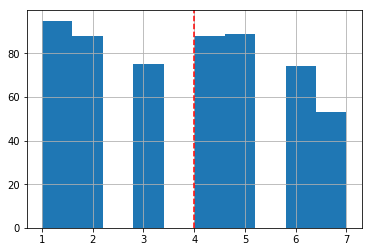

In [76]:
# Check out the distribution of days worn
n_user_days.hist()
plt.axvline(x=4, c='r', linestyle='--')

In [77]:
# Check out the actual counts within each wear day bin
n_user_days.value_counts().sort_index()

1    95
2    88
3    75
4    88
5    89
6    74
7    53
dtype: int64

In [78]:
# Drop users who don't have at least 4 days
keep_day_threshold = 4
n_user_days = n_user_days.loc[n_user_days >= keep_day_threshold].reset_index()

# Keep only seqn for joining purposes
n_user_days = n_user_days[['seqn']]

In [79]:
# Rejoin this set of ids into the pax_raw dataframe
pax_raw = pax_raw.merge(n_user_days, on='seqn', how='inner')

In [80]:
n_final_participants = pax_raw.seqn.nunique()
print(f'Total participants remaining in analysis set: {n_final_participants}')

Total participants remaining in analysis set: 304


In [84]:
# Save cleaned data to our hdf store
if using_sample:
        pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_clean_sample')
else:
    pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_clean')